# Part 5: Models (Continued)

In [1]:
# System
import pathlib
import glob
import os, os.path, shutil
# Data Exploration
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pandas as pd
import seaborn as sns
from PIL import Image
# Machine Learning
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
#Deep Learning
import tensorflow as tf
import keras
from keras.utils import plot_model ######
from keras import backend as K ##########
from keras import metrics
from keras.regularizers import l2,l1
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import img_to_array, ImageDataGenerator, array_to_img, load_img
from keras.metrics import AUC
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
def create_charts(cnn, cnn_model):
    """
    plot1: train & validatoin loss curves
    plot2: train & validatoin accuracy curves
    Plot3: confusion matrix
    Plot4: train & validation ROC curve and AUC score
    Summary Statistics
    
    """
    
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define train & validation accuracy
    train_auc = cnn_model.history['acc']
    val_auc = cnn_model.history['val_acc']
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION Accuracy
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
    # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
  
    names = ['True Positives', 'False Negatives', 'False Positives', 'True Negatives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['CORROSION', 'NOCORROSION']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    
    ## Summary Statistics
    TP, FN, FP, TN = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

In [5]:
train_dir = 'split/train'
train_CORROSION_dir = 'split/train/CORROSION/'
train_NOCORROSION_dir = 'split/train/NOCORROSION/'

validation_dir = 'split/validation'
validation_CORROSION_dir = 'split/validation/CORROSION/'
validation_NOCORROSION_dir = 'split/validation/NOCORROSION/'

test_dir = 'split/test'
test_CORROSION_dir = 'split/test/CORROSION/'
test_NOCORROSION_dir = 'split/test/NOCORROSION/'

In [4]:
# Build data generator function

def make_data_generator(
    train_datagen, train_dir, 
    val_datagen, val_dir, 
    test_datagen, test_dir):
    
    datagen_lst = [train_datagen, val_datagen, test_datagen]
    directory_lst = [train_dir, val_dir, test_dir]
    generator_lst = []
    for generator, directory in zip(datagen_lst, directory_lst):
        if directory == train_dir:
            shuffle = True
        else:
            shuffle = False
        g = generator.flow_from_directory(directory = directory,
                                         target_size = (128,128),
                                         batch_size = 64,
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         shuffle = shuffle,
                                         seed = 42
                                         )
        generator_lst.append(g)
    
    return generator_lst

In [5]:
# Load the images

train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   shear_range = 0.2,
                                   zoom_range = 0.2, 
                                   horizontal_flip = True,
                                   vertical_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = make_data_generator(
    train_datagen, train_dir,
    val_datagen, validation_dir,
    test_datagen, test_dir)

Found 1273 images belonging to 2 classes.
Found 364 images belonging to 2 classes.
Found 182 images belonging to 2 classes.


In [10]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

# Model 14: batch size = 64, Dropouts

In [22]:
 # Design the model
    
def build_model_64_1():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(128, 128, 3)))

    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(256, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    

    
    

    cnn.add(Flatten())
            
    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn_64_1 = build_model_64_1()

In [23]:
cnn_model_64_1 = cnn_64_1.fit_generator(train_generator,
                              epochs = 100,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1,
                              callbacks=[es])

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
20/20 [==============================] - 25s 1s/step - loss: 0.7001 - acc: 0.4959 - val_loss: 0.6900 - val_acc: 0.5440
Epoch 2/100
20/20 [==============================] - 24s 1s/step - loss: 0.6812 - acc: 0.5819 - val_loss: 0.6086 - val_acc: 0.7198
Epoch 3/100
20/20 [==============================] - 25s 1s/step - loss: 0.6030 - acc: 0.7075 - val_loss: 0.5987 - val_acc: 0.7445
Epoch 4/100
20/20 [==============================] - 24s 1s/step - loss: 0.5788 - acc: 0.7327 - val_loss: 0.5493 - val_acc: 0.7582
Epoch 5/100
20/20 [==============================] - 24s 1s/step - loss: 0.5480 - acc: 0.7533 - val_loss: 0.5516 - val_acc: 0.7473
Epoch 6/100
20/20 [==============================] - 24s 1s/step - loss: 0.5451 - acc: 0.7427 - val_loss: 0.5207 - val_acc: 0.7527
Epoch 7/100
20/20 [==============================] - 24s 1s/step - loss: 0.5202 - acc: 0.7533 - val_loss: 0.4765 - val_acc: 0.7967
Epoch 8/100
20/20 [==============================] - 24s 1s/step - loss: 0.4963 - a

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 81.87% | Precision = 85.11% | Recall = 80.81% | Specificity = 83.13% | F1 Score = 82.90%


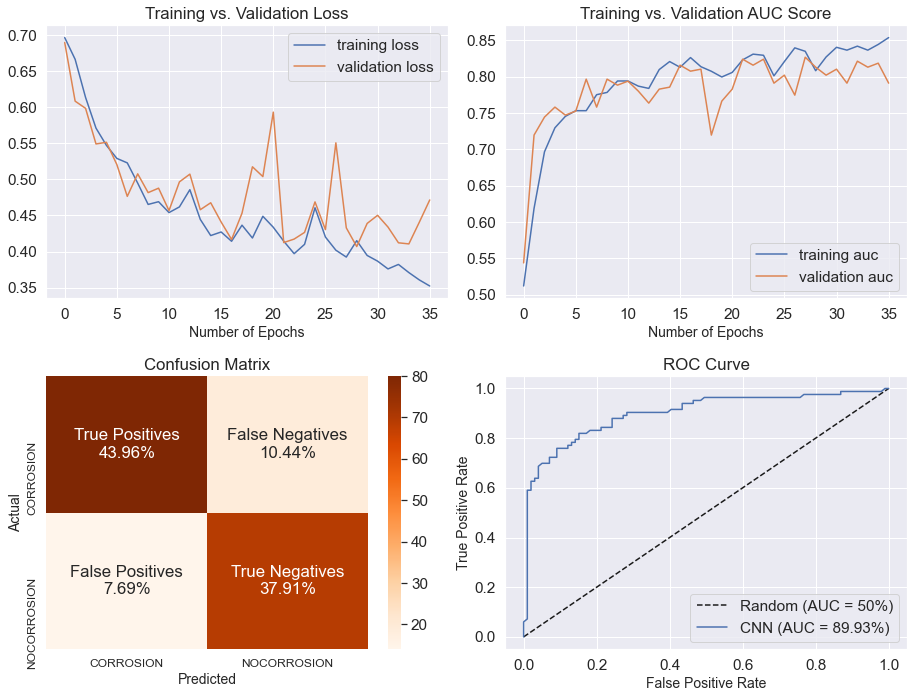

In [24]:
create_charts(cnn_64_1, cnn_model_64_1)

# Model 14: batch size = 64, Dropouts

In [18]:
 # Design the model
    
def build_model_64_2():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(128, 128, 3)))
    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
  

    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
   
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Flatten())
            
    cnn.add(Dense(256, activation='relu'))
#   cnn.add(Dense(128, activation='relu'))
#   cnn.add(Dense(64, activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn_64_2 = build_model_64_2()

In [19]:
cnn_model_64_2 = cnn_64_2.fit_generator(train_generator,
                              epochs = 100,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1,
                              callbacks=[es])

Epoch 1/100
20/20 [==============================] - 27s 1s/step - loss: 0.6977 - acc: 0.5092 - val_loss: 0.6710 - val_acc: 0.6346
Epoch 2/100
20/20 [==============================] - 26s 1s/step - loss: 0.6878 - acc: 0.5536 - val_loss: 0.6198 - val_acc: 0.7088
Epoch 3/100
20/20 [==============================] - 26s 1s/step - loss: 0.6370 - acc: 0.6633 - val_loss: 0.6466 - val_acc: 0.6566
Epoch 4/100
20/20 [==============================] - 26s 1s/step - loss: 0.6153 - acc: 0.6842 - val_loss: 0.5720 - val_acc: 0.7390
Epoch 5/100
20/20 [==============================] - 26s 1s/step - loss: 0.5594 - acc: 0.7263 - val_loss: 0.5990 - val_acc: 0.6923
Epoch 6/100
20/20 [==============================] - 26s 1s/step - loss: 0.5706 - acc: 0.7125 - val_loss: 0.5945 - val_acc: 0.7280
Epoch 7/100
20/20 [==============================] - 27s 1s/step - loss: 0.5386 - acc: 0.7467 - val_loss: 0.5445 - val_acc: 0.7775
Epoch 8/100
20/20 [==============================] - 26s 1s/step - loss: 0.5256 - a

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 86.81% | Precision = 86.41% | Recall = 89.90% | Specificity = 83.13% | F1 Score = 88.12%


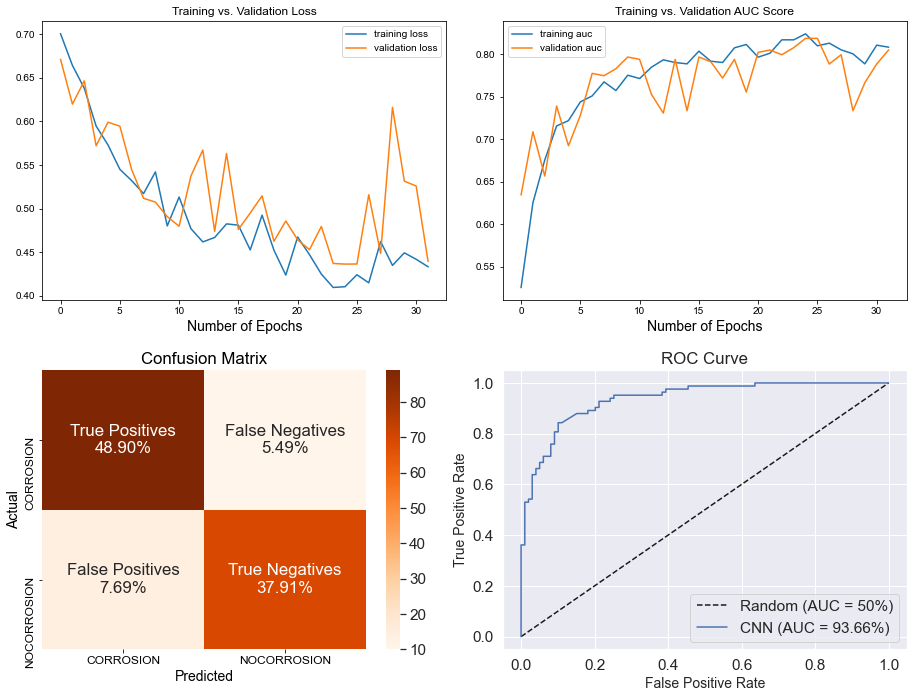

In [20]:
create_charts(cnn_64_2, cnn_model_64_2)

# Model 16: batch size = 64, Dropouts

In [25]:
 # Design the model
    
def build_model_64_3():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(128, 128, 3)))
    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
  

    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
   
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Flatten())
            
    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn_64_3 = build_model_64_3()

In [28]:
cnn_model_64_3 = cnn_64_3.fit_generator(train_generator,
                              epochs = 100,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1,
                              callbacks=[es])

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
20/20 [==============================] - 27s 1s/step - loss: 0.6948 - acc: 0.5313 - val_loss: 0.6901 - val_acc: 0.5440
Epoch 2/100
20/20 [==============================] - 26s 1s/step - loss: 0.6853 - acc: 0.5623 - val_loss: 0.6458 - val_acc: 0.6593
Epoch 3/100
20/20 [==============================] - 26s 1s/step - loss: 0.6370 - acc: 0.6661 - val_loss: 0.6535 - val_acc: 0.7363
Epoch 4/100
20/20 [==============================] - 26s 1s/step - loss: 0.6261 - acc: 0.7202 - val_loss: 0.5880 - val_acc: 0.7335
Epoch 5/100
20/20 [==============================] - 26s 1s/step - loss: 0.5755 - acc: 0.7249 - val_loss: 0.5971 - val_acc: 0.7390
Epoch 6/100
20/20 [==============================] - 26s 1s/step - loss: 0.5730 - acc: 0.7292 - val_loss: 0.5397 - val_acc: 0.7582
Epoch 7/100
20/20 [==============================] - 26s 1s/step - loss: 0.5338 - acc: 0.7640 - val_loss: 0.5544 - val_acc: 0.7500
Epoch 8/100
20/20 [==============================] - 26s 1s/step - loss: 0.5363 - a

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 86.81% | Precision = 90.32% | Recall = 84.85% | Specificity = 89.16% | F1 Score = 87.50%


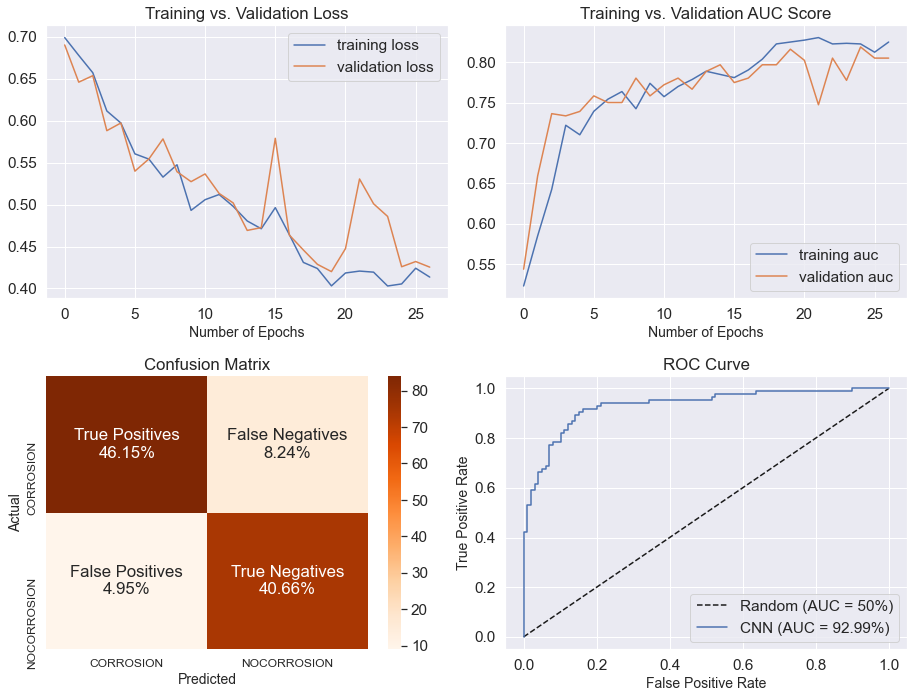

In [29]:
create_charts(cnn_64_3, cnn_model_64_3)

# Model 17: batch size = 32, Dropouts

In [6]:
# Build data generator function

def make_data_generator(
    train_datagen, train_dir, 
    val_datagen, val_dir, 
    test_datagen, test_dir):
    
    datagen_lst = [train_datagen, val_datagen, test_datagen]
    directory_lst = [train_dir, val_dir, test_dir]
    generator_lst = []
    for generator, directory in zip(datagen_lst, directory_lst):
        if directory == train_dir:
            shuffle = True
        else:
            shuffle = False
        g = generator.flow_from_directory(directory = directory,
                                         target_size = (256,256),
                                         batch_size = 32,
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         shuffle = shuffle,
                                         seed = 42
                                         )
        generator_lst.append(g)
    
    return generator_lst

In [7]:
# Load the images

train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   shear_range = 0.2,
                                   zoom_range = 0.2, 
                                   horizontal_flip = True,
                                   vertical_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = make_data_generator(
    train_datagen, train_dir,
    val_datagen, validation_dir,
    test_datagen, test_dir)

Found 1273 images belonging to 2 classes.
Found 364 images belonging to 2 classes.
Found 182 images belonging to 2 classes.


In [8]:
 # Design the model
    
def build_model_32_4():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(256, 256, 3)))
    
    cnn.add(Conv2D(256, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))

    
    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
  

    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Flatten())
            
    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn_32_4 = build_model_64_4()

In [11]:
cnn_model_32_4 = cnn_32_4.fit_generator(train_generator,
                              epochs = 100,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1,
                              callbacks=[es])

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
40/40 [==============================] - 242s 6s/step - loss: 0.7362 - acc: 0.5458 - val_loss: 0.6921 - val_acc: 0.4615
Epoch 2/100
40/40 [==============================] - 252s 6s/step - loss: 0.6892 - acc: 0.5326 - val_loss: 0.7666 - val_acc: 0.5467
Epoch 3/100
40/40 [==============================] - 272s 7s/step - loss: 0.6956 - acc: 0.6289 - val_loss: 0.6730 - val_acc: 0.5907
Epoch 4/100
40/40 [==============================] - 279s 7s/step - loss: 0.6311 - acc: 0.6700 - val_loss: 0.6023 - val_acc: 0.7060
Epoch 5/100
40/40 [==============================] - 276s 7s/step - loss: 0.5679 - acc: 0.7329 - val_loss: 0.6073 - val_acc: 0.7582
Epoch 6/100
40/40 [==============================] - 278s 7s/step - loss: 0.5541 - acc: 0.7524 - val_loss: 0.5798 - val_acc: 0.7280
Epoch 7/100
40/40 [==============================] - 260s 6s/step - loss: 0.5245 - acc: 0.7605 - val_loss: 0.4818 - val_acc: 0.7940
Epoch 8/100
40/40 [==============================] - 249s 6s/step - loss: 0.

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 86.81% | Precision = 84.40% | Recall = 92.93% | Specificity = 79.52% | F1 Score = 88.46%


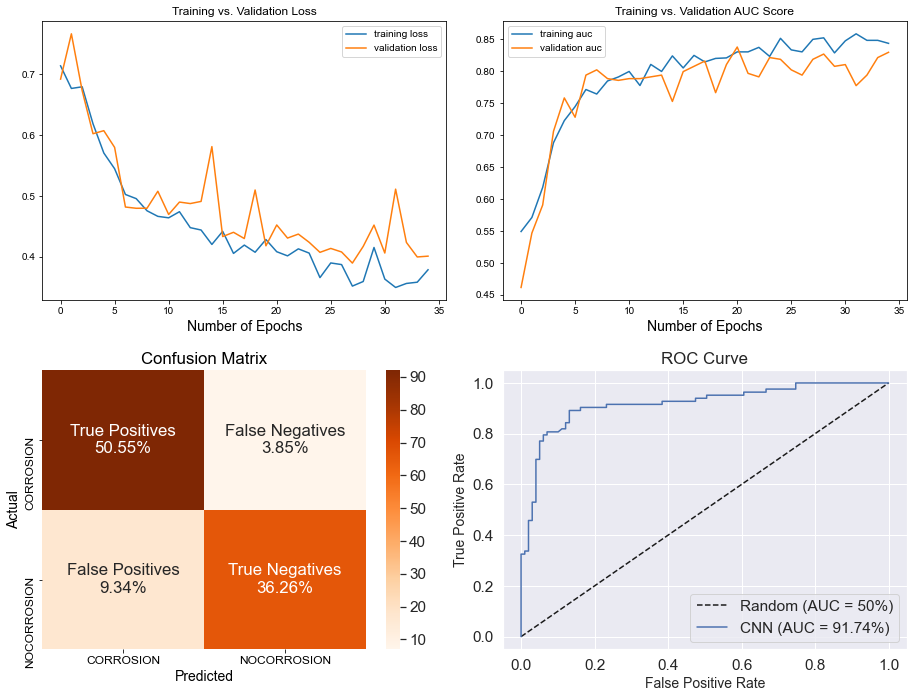

In [12]:
create_charts(cnn_32_4, cnn_model_32_4)

# Conclusion

Around 30 models were trained with different combinations of activations, number of feature maps, dropouts, l1/l2 regulations, and batch normalizations. The following is the architecture of my best-performance model.



![image.png](images/Model_Summary.png)

<img src= "images/CNN Architecture.jpg" alt="Trulli" style="width:100%">


The best performance model has four convolutional 2D layers, with each followed by a max-pooling layer. I also added a drop-out layer after each max-pooling layer to reduce overfitting to the training dataset. Finally, after being flattened, it is fed into a fully connected layer with ReLU activation. In the end, I used the sigmoid activation function to predict the output probabilities for this binary classification problem.

This research proposes building a deep learning model using the CNN method and automatically learning the corrosion behaviors to classify them. The results confirm that the implemented deep learning CNN algorithm is a promising tool for automated detection of corrosion. By giving a wide variety of corrosion images, our model can efficiently find the corrosion issues with high accuracy. 

# Future Work

In the future work, there is still room for improvement.

1.To increase the model's overall accuracy, increasing the number and diversity in the dataset is a must. Specifically, for corrosion detection and segmentation (i.e..., per-pixel labeling), it was found that there is a need for 65,000 labeled images required to achieve an essentially human-level accuracy for an A. I model (W. Nash, T. Drummond, N. Birbilis, Deep Learning AI for Corrosion Detection, in: NACE International (Ed.), Corros. 2019, Nashville, TN, 2019.).

2.In the context of model accuracy, the model training is influenced by the labeled images. The rate of model accuracy improvement is inherently linked to the quality of the image labeling. The identification of corrosion is a highly complex task. Labeling high-quality corrosion images require experts to have knowledge of a range of materials in an image. Also, it needs experts to assess the difference between what may be brown or red paint and corrosion. 

3.Including image segmentation and using U-Net CNN architecture further improves the model's overall performance to reach human-level accuracy of corrosion detection. Image segmentation can let you know where an object is located in the image, the shape of that object, which pixel belongs to which object, which helps understand the image at a much lower level. U-net is an architecture of semantic segmentation. It has been proven quite helpful for biomedical image segmentation. In corrosion detection, it is quite worthy of using the U-net architecture model to detect localized corrosion problems, including pit corrosion and crevice corrosion. 